Notebook created by Forrest Hooton

In [1]:
from time import time
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as mpatches
%matplotlib inline

In [ ]:
# For higher resolution production graphs
mpl.rcParams['figure.dpi']= 150

In [2]:
import sys
sys.path.append('./misc')

import misc.pubmed_util as PMD
from misc import collected_data_handling

# Loading and Formatting Data

In [3]:
# Function to quickly clean plot
def clean_plot():
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

# Problem inputing letters into csv, so created system to convert them here
def greek_letter_converter(chem, convert_letter = True):
    if convert_letter:
        chem = chem.replace('*alpha*', 'α')
        chem = chem.replace('*beta*', 'β')
        chem = chem.replace('*gamma*', 'γ')
        chem = chem.replace('*rho*', 'ρ')
        chem = chem.replace('*delta*', 'δ')
    else:
        chem = chem.replace('*alpha*', 'alpha')
        chem = chem.replace('*beta*', 'beta')
        chem = chem.replace('*gamma*', 'gamma')
        chem = chem.replace('*rho*', 'rho')
        chem = chem.replace('*delta*', 'delta')
    return chem

# Clean terms for various file applications
def clean_term(term, convert_letter = True, w_space = True, is_url=True):
    term = term.lower().strip()
    
    if convert_letter:
        term = greek_letter_converter(term)
    else:
        term = greek_letter_converter(term, convert_letter=False)
    
    if w_space:
        if is_url:
            term = term.replace(' ', '%20') # To replace ' ' in request
        else:
            pass
    else:
        term = term.replace(' ', '')
    return term

# Query pubchem for compound synonym info
def get_compound_pubchem_info(synonym):
    
    try:
        req = clean_term(synonym, convert_letter=False)
        compound_id, compound_name = PMD.retrieve_synonym_info(req)
    except:
        req = clean_term(synonym, convert_letter=False, w_space=False)
        compound_id, compound_name = PMD.retrieve_synonym_info(req)
    
    return compound_id, compound_name.lower()

In [4]:
import math

# Uses the foodb synonym file to create a synonym code for a df, and potentially cross reference the synonyms
# to another df to return what synonyms are unique
def append_synonyms(df, chem_key, use_foodb_key = True):
    
    if use_foodb_key:
        # Need to ensure document is in folder
        compound_synonyms = pd.read_csv('data/compound_synonymssql.csv')

        # Only keep columns with synonym and synonym id
        syn_reduced = compound_synonyms[['source_id', 'synonym']]
        syn_reduced = syn_reduced.rename(index=str, columns={"source_id": "chem_id_f"})
        syn_reduced.synonym = syn_reduced.synonym.str.lower()

        df[chem_key] = df[chem_key].str.strip().str.lower()
        
        df = df.merge(syn_reduced, how = 'left', left_on = chem_key, right_on = 'synonym')
        
        # Dataframe with contents of foodb
        foodb = pd.read_csv('data/contentssql.csv')

        # Gets the subset of the database pertaining to garlic
        foodb = foodb[['source_id', 'orig_source_name']].drop_duplicates()

        # Transforms all the chemical names to lowercase for syncing
        foodb.orig_source_name = foodb.orig_source_name.str.lower()

        # Creates a list of the unique chemicals in garlic from foodb
        foodb_lower = list(set( foodb.orig_source_name.tolist() ))
        
        # Some chemicals don't occur in the foodb spreadsheet for some reason, so need to match by the word to detect if
        # the chemical is in garlic
        for idx, row in df.fillna('placeholder').iterrows():
            if row[chem_key] in foodb_lower:
                if df.loc[idx, 'chem_id_f'] == 'placeholder':
                    df.at[idx, 'chem_id_f'] = foodb[foodb['orig_source_name'] == row[chem_key]].source_id.tolist()[0]
        
        usda = pd.read_csv('data/usda_raw_garlic.csv', encoding = 'latin1')
        usda.nut_desc = usda.nut_desc.str.lower()
        usda_lower = list(set( usda.nut_desc.tolist() ))
        
        # the chemical is in garlic
        for idx, row in df.fillna('placeholder').iterrows():
            if row[chem_key] in usda_lower:
                df.at[idx, 'chem_id_f'] = usda[usda['nut_desc'] == row[chem_key]].chem_id.tolist()[0]
                
    else:
        start = time()

        for idx, row in df.iterrows():
            try:
                ID, name = get_compound_pubchem_info(row[chem_key])
                df.at[idx, 'chem_id_p'] = ID
                df.at[idx, 'pubchem_name'] = name
                
            except:
                pass
            
            if not idx % 20:
                print(idx, 'chems searched in', (time() - start) /60, "min")

        print("Pubchem ids added in", (time() - start) /60, "min")
    
    return df


# Assign keys to all compounds in dataframe
# chem_key is the pandas column that contains chemical strings
def id_loader(df, chem_key, load, file, fdb = True, pubchem = True):
    
    if not load:
        if pubchem:
            df = append_synonyms(df, chem_key, use_foodb_key=False)
        if fdb:
            df = append_synonyms(df, chem_key)
        
        total = len(df[chem_key].drop_duplicates())
        
        num_covered = len(df[df.chem_id_p.notnull()].chem_id_p.drop_duplicates())
        print('Pubchem unique compound coverage', num_covered / total, '%')
        
        num_covered = len(df[df.chem_id_f.notnull()].chem_id_f.drop_duplicates())
        print('FooDB unique compound coverage', num_covered / total, '%')
        
        # The maximum pubchem index to make sure id's don't overlap
        max_p_index = 134825000
        
        for idx, row in df.iterrows():
            if not math.isnan(row['chem_id_p']):
                df.at[idx, 'chem_id'] = row['chem_id_p']
            else:
                df.at[idx, 'chem_id'] = row['chem_id_f'] + max_p_index
        
        num_covered = len(df[df.chem_id.notnull()].chem_id.drop_duplicates())
        print('Total unique compound covereage', num_covered / total, '%')

        file = 'misc_save/' + file
        df.to_pickle(file)
    
    return df

In [61]:
i = 1

def config(i):
    if i == 1:
        food = 'garlic'
    elif i == 2:
        food = 'cocoa'
    
    return food

food = config(i)
load = True

## Pilot Data

In [76]:
def load_raw_data(food, load):
    if load:
        food_data = pd.read_pickle(f'misc_save/{food}_food_data.pkl')
    else:
        food_data = pd.read_csv(f'data/{food}_data.csv', encoding='latin1')
    
    food_scoring = pd.read_csv(f'data/{food}_scoring.csv', encoding='latin1')

    # Need to remove phenol explorer ids that were manually put into data (for garlic only)
    food_data = food_data[food_data.PMID.isin(food_scoring.PMID.tolist())]

    food_data.chemical = food_data.chemical.str.lower()
    food_data.amount = food_data.amount.str.replace(',', '')

    food_data = food_data.merge(food_scoring[['PMID','is_useful']], how = 'left', on = 'PMID')
    
    return food_data, food_scoring

food_data, food_scoring = load_raw_data(food, load)

In [33]:
def append_keys_raw_data(food_data, food):
    food_data = id_loader(food_data, 'chemical', load, f'{food}_food_data.pkl')
    
    return food_data

food_data = append_keys_raw_data(food_data, food)

In [63]:
# Number of unique papers in garlic_test.csv
print('Number of unique papers:', len(food_data['PMID'].drop_duplicates()))
print('Total number of records:', len(food_data))

Number of unique papers: 77
Total number of records: 1426


In [64]:
# Make units processable
# Not all units were entered cleanly, so this function ensures that the data works for collected_data_handling
def unit_clean(df):
    df.units = df.units.replace('ug/ml', 'ug/L')
    df.units = df.units.replace('U/ml', 'ug/L')
    df.units = df.units.replace('mg/ml', 'ug/L')
    df.units = df.units.replace('mg/l', 'ug/L')
    df.units = df.units.replace('g/l', 'ug/L')
    df.units = df.units.replace('mM', 'ug/L')
    df.units = df.units.replace('mg/ ECE g', 'ug/L')
    df.units = df.units.replace('m/z', '%')
    df.units = df.units.replace('mg/lg', 'ug/L')
    df.units = df.units.replace('mmol/g', 'ug/L')
    df.units = df.units.replace('-', 'ug/L')

    df.amount = df.amount.str.strip('~')
    df.amount = df.amount.str.strip('<')

    df.amount = df.amount.replace('not quantified', '0')
    df.amount = df.amount.replace('LOD', '0')
    df.amount = df.amount.replace('ND', '0')
    df.amount = df.amount.replace('NQ', '0')
    df.amount = df.amount.replace('nd', '0')
    df.amount = df.amount.replace('n.q', '0')
    df.amount = df.amount.replace('n.q.', '0')
    df.amount = df.amount.replace('no analyzed', '0')
    df.amount = df.amount.replace('-', '0')
    
    return df

def clean_raw_data_strings(food_data):
    food_data.chemical = food_data.chemical.apply(clean_term, is_url=False)
    food_data = unit_clean(food_data)
    
    return food_data

food_data = clean_raw_data_strings(food_data)

In [65]:
# Partition data into quantified and unquantified
def partition_raw_data(food_data, food_scoring):

    for idx, row in food_data.iterrows():
        try:
            row['units'].count('g')
        except:
            print(row['units'])

        if row['units'].count('g') > 1:
            food_data.at[idx, 'is_quant'] = 1
        else:
            food_data.at[idx, 'is_quant'] = 0

    # Remove all rows where the units are %'s
    food_data_q = food_data[food_data['is_quant'] == 1].reset_index(drop=True)

    # Have a seperate dataframe for all chemicals that we would put in the category of 'detected but not quantified'
    food_data_dnq = food_data[food_data['is_quant'] == 0].reset_index(drop=True)

     # The quantified dataframe for values that are both quantified and unquantified
    unq_chems = list(set( food_data_dnq['chemical'].tolist() ))
    food_data_both = food_data_q.iloc[[idx for idx, row in food_data_q.fillna('placeholder').iterrows() if row['chemical'] in unq_chems]]

    # Remove occurances of overlaping chemicals from the unquantified garlic data
    q_chems = list(set( food_data_q['chemical'].tolist() ))
    food_data_dnq = food_data_dnq.iloc[[idx for idx, row in food_data_dnq.fillna('placeholder').iterrows() if row['chemical'] not in q_chems]]
    
    return food_data_q, food_data_dnq

food_data_q, food_data_dnq = partition_raw_data(food_data, food_scoring)

In [66]:
# Creates food_mine database data from raw collected data
def build_food_mine(food_data, food_data_q, food_data_dnq):
    food_mine = collected_data_handling.dict_to_df(food_mine)

    quant_food_mine = collected_data_handling.dict_to_df(quant_food_mine)

    unquant_food_mine = collected_data_handling.dict_to_df(food_data_dnq)
        
    return food_mine, quant_food_mine, unquant_food_mine

food_mine, quant_food_mine, unquant_food_mine = build_food_mine(food_data, food_data_q, food_data_dnq)

In [52]:
# Need to recompare quantified chems and unquantified chems with synonym key to do one last removal
q_chems = list(set( quant_food_mine['chem_id'].tolist() ))
unquant_food_mine = unquant_food_mine.iloc[[idx for idx, row in unquant_food_mine.fillna('placeholder').iterrows() if row['chem_id'] not in q_chems]].reset_index()

## FooDB Data

In [53]:
# Loads data from FooDB
def load_foodb_data(food, load):
    # Dataframe with contents of foodb
    
    fdb_download = False
    if fdb_download:
        foodb = pd.read_csv('contentssql.csv')

        if food == 'garlic':
            # Garlic - ["Garlic", "Soft-necked Garlic"]
            target_foodb_food_id = [8, 880]

        if food == 'cocoa':
            # Cocoa - ["cocoa bean", "cocoa butter", "Cocoa powder", "Cocoa Liquor"]
            target_foodb_food_id = [182, 706, 707,708]

        else:

            # Gets the subset of the database pertaining to food
            f = lambda x: x in target_foodb_food_id
            foodb_food = foodb[foodb.food_id.map(f)].reset_index(drop=True)

            # Transforms all the chemical names to lowercase for syncing
            foodb_food.orig_source_name = foodb_food.orig_source_name.str.lower()

            foodb_food = foodb_food.rename(index=str, columns={"source_id": "chem_id_f"})
    
    else:
        foodb_food = pd.read_pickle(f'data/foodb_{food}.pkl')
        
        foodb_food = foodb_food.rename(columns={'chemical' : 'orig_source_name', 'average': 'standard_content',
                                                'reference' : 'orig_source_id'})
    if load:
        foodb_food = pd.read_pickle(f'misc_save/{food}_foodb_food.pkl')
                
    foodb_food = id_loader(foodb_food, 'orig_source_name', load, f'{food}_foodb_food.pkl')

    # Creates a list of the unique chemicals in garlic from foodb
    foodb_food_lower = list(set( foodb_food.chem_id.tolist() ))

    # Creates a seperate dataframe that holds chemicals for garlic in foodb with a real quantification
    quant_foodb_food = foodb_food[foodb_food.standard_content.notnull()][['chem_id', 'orig_source_id','orig_source_name', 'standard_content']].drop_duplicates()

    # Creates a seperate dataframe that holds chemicals for garlic in foodb without a real quantification
    unquant_foodb_food = foodb_food[foodb_food.standard_content.isnull()][['chem_id', 'orig_source_id', 'orig_source_name', 'standard_content']].reset_index()

    q_ids = list(set( quant_foodb_food.chem_id.tolist() ))
    unquant_foodb_food = unquant_foodb_food.iloc[[idx for idx, row in unquant_foodb_food.iterrows() if row['chem_id'] not in q_ids],:]
    
    return foodb_food, quant_foodb_food, unquant_foodb_food

foodb_food, quant_foodb_food, unquant_foodb_food = load_foodb_data(food, load)

## USDA Data

In [54]:
# Loads USDA data
def load_usda_data(food, load):

    if food == 'garlic':
        # Garlic, 'Garlic, raw', 'Spices, garlic powder'
        NDB_id = [11215, 2020]

    if food == 'cocoa':
        # Cocoa, 'Oil, cocoa butter', 'Cocoa, dry powder, Hershey's European style cocoa', 
        # 'Cocoa, dry powder, unsweetened', 'Cocoa, dry powder, unsweetend, processed with alkali',
        # 'Cocoa, dry powder, hi-fat or breakfast, processed with alkali'
        NDB_id = [4501, 19171, 19165, 19166, 19860]

    # Reads in USDA database
    usda = pd.read_csv('data/SR28_plus_flav.csv', encoding = 'latin1')

    # Filters out rows not apart of NDB_id
    f = lambda x: x in NDB_id
    usda = usda[usda.NDB_No.map(f)][['NDB_No','food_name', 'Nutr_No_new', 'nut_desc', 'Nutr_Val', 'unit']]
    usda['num_measures'] = 1

    # Average chemicals that appear in multiple USDA food catagoriess
    for nutr in usda.Nutr_No_new.drop_duplicates().tolist():
        temp = usda[usda.Nutr_No_new == nutr]
        if len(temp) > 1:
            if len(temp.unit.drop_duplicates()) > 1:
                print(nutr, 'has different units for same nutrient')
            new_row = temp.copy().reset_index(drop=True).loc[0,:]
            new_row['Nutr_Val'] = temp.Nutr_Val.mean()
            new_row['num_measures'] = len(temp)

            usda = usda.drop(temp.index)
            usda = usda.append(new_row)

    usda = usda.reset_index(drop=True)

    # Append chemical key matcher to USDA chemicals
    if load:
        usda = pd.read_pickle(f'misc_save/{food}_usda.pkl')
    else:
        usda = id_loader(usda, 'nut_desc', load, f'{food}_usda.pkl').reset_index(drop=True)

    return usda

usda = load_usda_data(food, load)

C:\Users\forresthooton\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


# Might Need to move this

In [55]:
# Compares databases to show percise differences
def compare_chems(df, df_key, quant_identifiers, unquant_identifiers):
    
    identifiers = quant_identifiers + unquant_identifiers
    
    # Calculates number of unique chems
    neg_comparison_df = df.iloc[[idx for idx, row in df.fillna('placeholder').iterrows() if row[df_key] not in identifiers], :]
    #display(neg_comparison_df)
    neg_num_chems = len(neg_comparison_df)
    neg_num_chems_w_synonyms = len(neg_comparison_df[neg_comparison_df[df_key].notnull()][df_key].drop_duplicates()) + len(neg_comparison_df[neg_comparison_df[df_key].isnull()])
    
    print('Num unique chems:', neg_num_chems)
    print('Num unique chems, accounting for synonyms:', neg_num_chems_w_synonyms, '<-')
    
    pos_comparison_df = df.iloc[[idx for idx, row in df.fillna('placeholder').iterrows() if row[df_key] in identifiers], :].reset_index()
    
    pos_num_chems = len(pos_comparison_df)
    pos_num_chems_w_synonyms = len(pos_comparison_df[pos_comparison_df[df_key].notnull()][df_key].drop_duplicates()) + len(pos_comparison_df[pos_comparison_df[df_key].isnull()])
    
    print('Num overlapping chems:', pos_num_chems)
    print('Num overlapping chems, accounting for synonyms:', pos_num_chems_w_synonyms)
    
    # Need to find the splits of quantified and unquantified chemicals from the subset overlapping with foodb
    quant_comparison_df = pos_comparison_df.iloc[[idx for idx, row in pos_comparison_df.fillna('placeholder').iterrows() if row[df_key] in quant_identifiers], :]
    unquant_comparison_df = pos_comparison_df.iloc[[idx for idx, row in pos_comparison_df.fillna('placeholder').iterrows() if row[df_key] in unquant_identifiers], :]
    
    quant_num_chems = len(quant_comparison_df)
    quant_num_chems_w_synonyms = len(quant_comparison_df[quant_comparison_df[df_key].notnull()][df_key].drop_duplicates()) + len(quant_comparison_df[quant_comparison_df[df_key].isnull()])
    
    unquant_num_chems = len(unquant_comparison_df)
    unquant_num_chems_w_synonyms = len(unquant_comparison_df[unquant_comparison_df[df_key].notnull()][df_key].drop_duplicates()) + len(unquant_comparison_df[unquant_comparison_df[df_key].isnull()])
    
    print('Num overlapping chems - quantified, accounting for synonyms:', quant_num_chems_w_synonyms, '<-')
    
    print('Num overlapping chems - unquantified, accounting for synonyms:', unquant_num_chems_w_synonyms, '<-')
    
    print('---------------------------------------------------------------------------------')
    
    total_n_chems = neg_num_chems_w_synonyms + quant_num_chems_w_synonyms + unquant_num_chems_w_synonyms
    
    return total_n_chems, neg_num_chems_w_synonyms, quant_num_chems_w_synonyms, unquant_num_chems_w_synonyms

def get_unique_df(df, df_key, quant_identifiers, unquant_identifiers):
    identifiers = quant_identifiers + unquant_identifiers
    
    # Calculates number of unique chems
    neg_comparison_df = df.iloc[[idx for idx, row in df.fillna('placeholder').iterrows() if row[df_key] not in identifiers], :]
    
    return neg_comparison_df.reset_index(drop=True)

In [56]:
quant_foodb_chem_ids = quant_foodb_food[quant_foodb_food['chem_id'].notnull()].chem_id.tolist() + usda[usda.chem_id.notnull()].chem_id.tolist()
unquant_foodb_chem_ids = unquant_foodb_food[unquant_foodb_food['chem_id'].notnull()].chem_id.tolist()
ntotal_qchems, nunique_qchems, n_qqchems, n_quchems = compare_chems(quant_food_mine, 'chem_id', quant_foodb_chem_ids, unquant_foodb_chem_ids)

Num unique chems: 322
Num unique chems, accounting for synonyms: 322 <-
Num overlapping chems: 83
Num overlapping chems, accounting for synonyms: 83
Num overlapping chems - quantified, accounting for synonyms: 60 <-
Num overlapping chems - unquantified, accounting for synonyms: 24 <-
---------------------------------------------------------------------------------


In [57]:
ntotal_uchems, nunique_uchems, n_uqchems, n_uuchems = compare_chems(unquant_food_mine, 'chem_id', quant_foodb_chem_ids, unquant_foodb_chem_ids)

Num unique chems: 191
Num unique chems, accounting for synonyms: 191 <-
Num overlapping chems: 13
Num overlapping chems, accounting for synonyms: 13
Num overlapping chems - quantified, accounting for synonyms: 10 <-
Num overlapping chems - unquantified, accounting for synonyms: 6 <-
---------------------------------------------------------------------------------


In [58]:
unique_chems = get_unique_df(quant_food_mine, 'chem_id', quant_foodb_chem_ids, unquant_foodb_chem_ids)

unique_chems.to_pickle(f'misc_save/{food}_unique_fm.pkl')

In [59]:
quant_food_mine.to_pickle(f'misc_save/{food}_quant_fm.pkl')

# Visualization Analysis

### Figure 1

Number of Record Histogram 1426


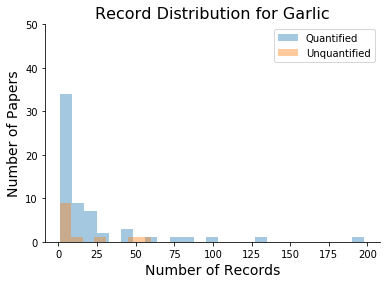

In [59]:
_, ax = plt.subplots(figsize=(6, 4))

# Distrubtion of chemical measurements per paper (number of records)
quant_viz = pd.DataFrame(food_data_q.groupby('PMID').count())
unquant_viz = pd.DataFrame(food_data_dnq.groupby('PMID').count())

yupperbound = 50

print("Number of Record Histogram", len(food_data))

g1 = sns.distplot(quant_viz.chemical, kde=False, label='Quantified')
g2 = sns.distplot(unquant_viz.chemical, kde=False, label='Unquantified')
g1.set_ylim(top = yupperbound)
g1.set_xlabel('Number of Records', fontsize=14)
g1.set_ylabel('Number of Papers', fontsize=14)

g1.set_title(f'Record Distribution for {food.capitalize()}', fontsize=16)

g1.legend()
clean_plot()

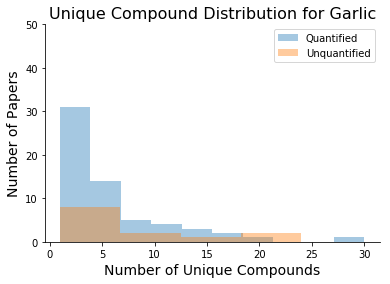

In [62]:
# Distrubtion of chemical measurements per paper (number of records)
quant_viz = pd.DataFrame(food_data_q[['PMID', 'chemical']].drop_duplicates().groupby('PMID').count())
unquant_viz = pd.DataFrame(food_data_dnq[['PMID', 'chemical']].drop_duplicates().groupby('PMID').count())

g1 = sns.distplot(quant_viz.chemical, kde=False, label='Quantified')
g2 = sns.distplot(unquant_viz.chemical, kde=False, label='Unquantified')
g1.set_ylim(top = yupperbound)
g1.set_xlabel('Number of Unique Compounds', fontsize=14)
g1.set_ylabel('Number of Papers', fontsize=14)

g1.set_title(f'Unique Compound Distribution for {food.capitalize()}', fontsize=16)

g1.legend()
clean_plot()

### Figure 2

In [77]:
# Load data for chemical classes
if food == 'garlic':
    classdata = pd.read_csv("data/Garlic_Quant_Cleaned.csv", encoding='latin1')
if food == 'cocoa':
    classdata = pd.read_csv("data/cocoa_quant_cleaned.csv", encoding='latin1')

classdata = classdata[['name','InChIKey', 'SuperClass', 'Class', 'SubClass']]
classdata.columns = ['chemical', 'InChiKey', 'SuperClass', 'Class', 'SubClass']

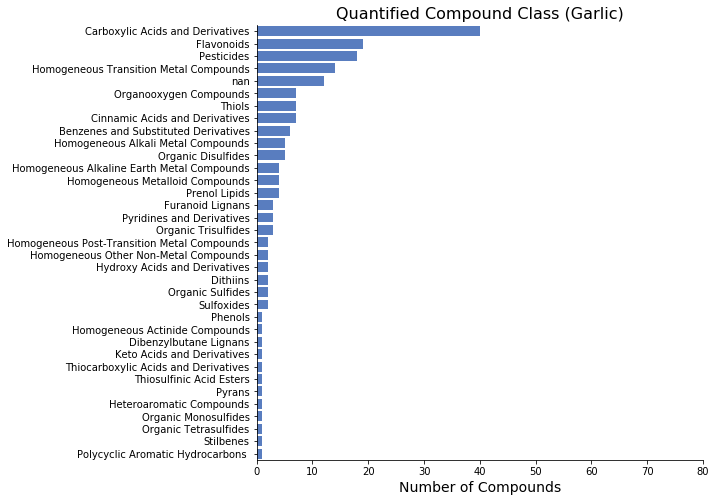

In [78]:
sns.set_color_codes(palette='muted')

fig, _ = plt.subplots(figsize=(8,8))
terms = classdata.Class.tolist()
top_n = 100 # Ensurces all classes are present

counter = Counter(terms)

# Get counts of classes
counter = dict(counter.most_common(top_n))

# Extract ordered keys and corresponding values, then plot
terms = [str(k) for k in counter.keys()]
term_counts = list(counter.values())
ax = sns.barplot(term_counts, terms, color='b')

ax.set_title(f'Quantified Compound Class ({food.capitalize()})', fontsize=16)

ax.set_xlabel('Number of Compounds', fontsize=14)
ax.set_xlim([0, 80])
clean_plot()

### Figure 3

In [69]:
# Colors at https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/

# Id's from quantified FooDB compounds
qids = foodb_food[foodb_food.standard_content.notnull() & foodb_food.chem_id.notnull()].chem_id.drop_duplicates().tolist()

# Names of quantified FooDB compounds without ids
qids = qids + foodb_food[foodb_food.standard_content.notnull() & foodb_food.chem_id.isnull()].orig_source_name.drop_duplicates().tolist()

# Total number of quantified compounds in FooDB
fdb_quant_num = len(qids)

# Total number of unquantified FooDB compounds with similar patterns
fdb_unquant_num = len([i for i in foodb_food[foodb_food.standard_content.isnull() & foodb_food.chem_id.notnull()].chem_id.drop_duplicates().tolist() if i not in qids])
fdb_unquant_num = fdb_unquant_num + len([i for i in foodb_food[foodb_food.standard_content.isnull() & foodb_food.chem_id.isnull()].orig_source_name.drop_duplicates().tolist() if i not in qids])


unquantcolor = sns.color_palette("Paired", 10)[1]
quantcolor = sns.color_palette("Paired", 10)[0]
uniquecolor = sns.color_palette("Paired")[6]

In [80]:
# Visualize final chems
disp_nums = {'db' : ['USDA', 'Foodb', 'Pilot', 'Pilot, New Info'], 'Quantified' : [len(usda), fdb_quant_num, ntotal_qchems, nunique_qchems], 'Unquantified' : [0, fdb_unquant_num, ntotal_uchems, 0]}
disp_df = pd.DataFrame(disp_nums)

disp_df['total'] = disp_df['Quantified'] + disp_df['Unquantified']
disp_df

NameError: name 'fdb_quant_num' is not defined

NameError: name 'disp_df' is not defined

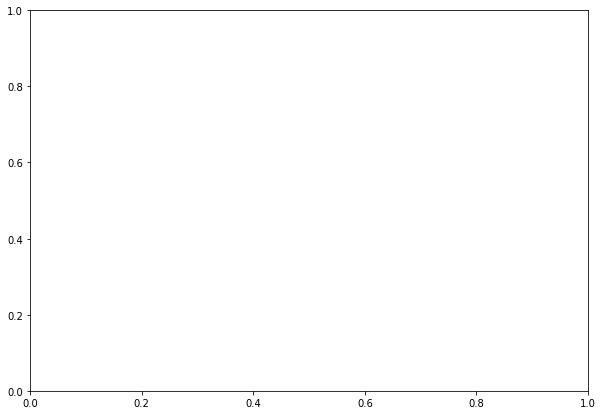

In [79]:
import matplotlib.pyplot as plt

index = np.arange(4)
bar_width = .5

fig, ax = plt.subplots(figsize=(10,7))

# Create stacked Quantified and Unquantified bar plots
ax.bar(index, disp_df['Quantified'], bar_width, color = quantcolor)
ax.bar(index, disp_df['Unquantified'], bar_width, bottom = disp_df['Quantified'], color = unquantcolor)

ax.set_ylim(0, 700)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Number of Unique Compounds', fontsize = 14)

fig.suptitle(f'Database Compound Comparison ({food.capitalize()})', fontsize = 16)

plt.xticks(index, ('USDA','FooDB', 'Pilot', 'Pilot, New Info'))
ax.get_children()[3].set_color(uniquecolor)

# Create Legend Labels
patch1 = mpatches.Patch(color=quantcolor, label='Quantified')
patch2 = mpatches.Patch(color=unquantcolor, label='Unquantified')
patch3 = mpatches.Patch(color=uniquecolor, label='Novel to Pilot (Quant)')
ax.legend(handles = [patch1, patch2, patch3], frameon = False, loc='upper left', bbox_to_anchor=(1, 1))

### Figure 4

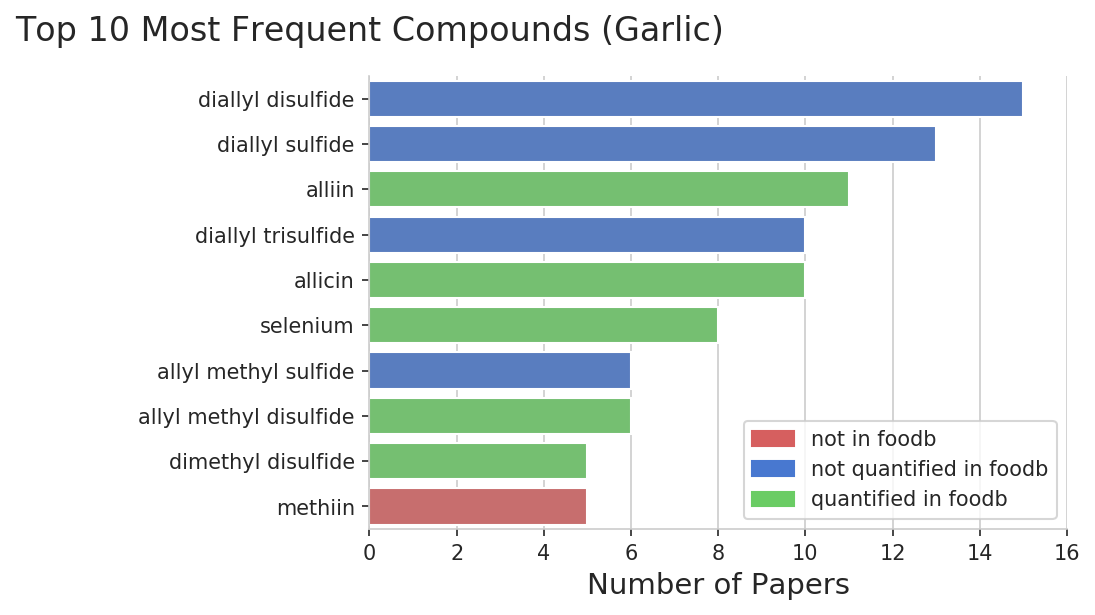

In [67]:
# Calculates top n for number of papers a chemical occurs in
expanded_term_list = []
for idx, row in food_mine.iterrows():
    expanded_term_list += [row['chem_id']] * int(row['num_papers'])

# Note that this particular iteration doesn't account for id's that are NaN, but all top values seem to have id's anyways
id_to_name = []
for ID in expanded_term_list:
    name = food_mine[food_mine['chem_id'] == ID].chemical.tolist()
    
    if isinstance(name, list):
        if len(name) == 0:
            continue
        id_to_name.append(name[0])
    else:
        id_to_name.append(name)

terms = id_to_name
top_n = 10

title = f"Top 10 Most Frequent Compounds ({food.capitalize()})"

f_ids = set(foodb_food.chem_id.tolist())
f_q_ids = set( foodb_food[foodb_food.standard_content > 0].chem_id.tolist())

counter = Counter(terms)

counter = dict(counter.most_common(top_n))

terms = [str(k) for k in counter.keys()]
term_counts = list(counter.values())

sns.set_color_codes('muted')

c1 = 'r'
c2 = 'b'
c3 = 'g'

colors = []
labels = []
for v in terms:
    temp_id = food_mine[food_mine.chemical==v].chem_id.tolist()[0]
    
    if temp_id in f_q_ids:
        colors.append(c3) # quantified in foodb
    elif temp_id in f_ids:
        colors.append(c2) # not quantified in foodb
    else:
        colors.append(c1) # not in foodb

# Horizontal bar graph

with sns.axes_style('whitegrid'):

    ax = sns.barplot(term_counts, terms, palette=colors)
    #ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Number of Papers', fontsize=14)
    ax.set_title(title, fontsize = 16)
    ax.title.set_position([0, 1.05])

    patch1 = mpatches.Patch(color=c1, label='not in foodb')
    patch2 = mpatches.Patch(color=c2, label='not quantified in foodb')
    patch3 = mpatches.Patch(color=c3, label='quantified in foodb')
    ax.legend(handles = [patch1, patch2, patch3])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim(right = 16)


### Figure 5

In [88]:
usda_mod = usda[(usda.unit != 'IU') & (usda.chem_id.notnull())]

for idx, row in usda_mod.iterrows():
    try:
        usda_mod.at[idx, 'usda_amount'] = collected_data_handling.__unit_handler__(row['Nutr_Val'], row['unit'] + '/100g', 'mg/100g')
    except:
        pass

usda_mod['units'] = 'mg/100g'

usda_mod.to_pickle(f'misc_save/{food}_usda_conv.pkl')

C:\Users\forresthooton\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\forresthooton\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\forresthooton\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [89]:
val_comparison = quant_food_mine.merge(usda_mod[['chem_id','usda_amount']], how = 'inner', on = 'chem_id')
print('Number of foodmine measurments of 0:', len(val_comparison[val_comparison.average_mean == 0]))
print('Number of usda measurments of 0:', len(val_comparison[val_comparison.usda_amount == 0]))
val_comparison = val_comparison[val_comparison.num_terms_quantified != 0]
val_comparison = val_comparison[(val_comparison.average_mean != 0) & (val_comparison.usda_amount != 0)]
val_comparison = val_comparison.sort_values(by=['average_mean'], ascending=False).reset_index(drop=True)

Number of foodmine measurments of 0: 0
Number of usda measurments of 0: 3


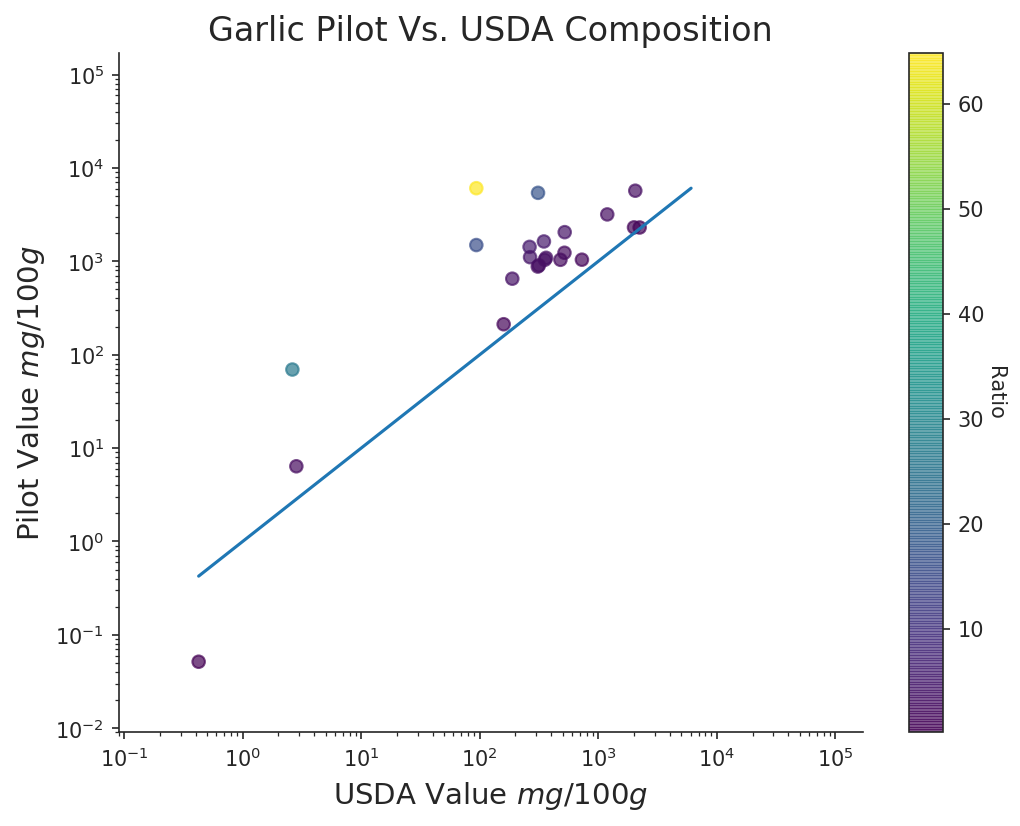

In [98]:
import math

color_values = [(row['average_mean'])/(row['usda_amount']) for _, row in val_comparison.iterrows()]

input1 = val_comparison['usda_amount'].tolist()
input2 = val_comparison['average_mean'].tolist()

x_min = 10**-1
x_max = 10**5
y_min = 10**-2
y_max = 10**5

if x_min == 0 or y_min == 0:
    x_min = max(x_min,y_min)
    y_min = max(x_min,y_min)

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot([min(input1), max(input2)],[min(input1), max(input2)])

    f = ax.scatter(input1, input2, c=color_values,
               cmap='viridis', marker='o', alpha=.7)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([x_min * .9, x_max * 1.7])
    ax.set_ylim([y_min * .9, y_max * 1.7])

    ax.set_xlabel(r"USDA Value $mg/100g$", fontsize=14)
    ax.set_ylabel(r"Pilot Value $mg/100g$", fontsize=14)
    
    ax.set_title(f'{food.capitalize()} Pilot Vs. USDA Composition', fontsize=16)

    cbar = plt.colorbar(f)
    cbar.set_label('Ratio', rotation=270, labelpad=+10)

    wnames = False
    if wnames:
        for i, txt in enumerate(val_comparison.chemical.tolist()):
            plt.annotate(txt, (input1[i] * 1.1, input2[i]))

    clean_plot()

### Figure 6

In [20]:
def cdf_df(df, valcol):
    df = df.sort_values(by=[valcol]).reset_index(drop=True)
    n = len(df)
    for idx, row in df.iterrows():
        df.at[idx,'cdf'] = (idx + 1) / n
    return df

def standardize_units(df, valcolumn, unitcolumn):
    for idx, row in df.iterrows():
        try:
            df.at[idx, 'conv_amount'] = collected_data_handling.__unit_handler__(row[valcolumn], row[unitcolumn] + '/100g', 'mg/100g')
        except:
            pass
    return df

In [18]:
garlic_u = pd.read_pickle('misc_save/garlic_unique_fm.pkl')
cocoa_u = pd.read_pickle('misc_save/cocoa_unique_fm.pkl')

In [21]:
garlic_u = garlic_u[garlic_u.average_mean > 0]
g_cdf = cdf_df(garlic_u, 'average_mean')

cocoa_u = cocoa_u[cocoa_u.average_mean > 0]
c_cdf = cdf_df(cocoa_u, 'average_mean')

In [22]:
usdag = pd.read_pickle('misc_save/garlic_usda.pkl')
usdag = standardize_units(usdag, 'Nutr_Val', 'unit')
usdag = usdag[usdag.conv_amount.notnull()]
usdag = usdag[usdag.conv_amount > 0]
usdag = cdf_df(usdag, 'conv_amount')

usdac = pd.read_pickle('misc_save/cocoa_usda.pkl')
usdac = standardize_units(usdac, 'Nutr_Val', 'unit')
usdac = usdac[usdac.conv_amount.notnull()]
usdac = usdac[usdac.conv_amount > 0]
usdac = cdf_df(usdac, 'conv_amount')

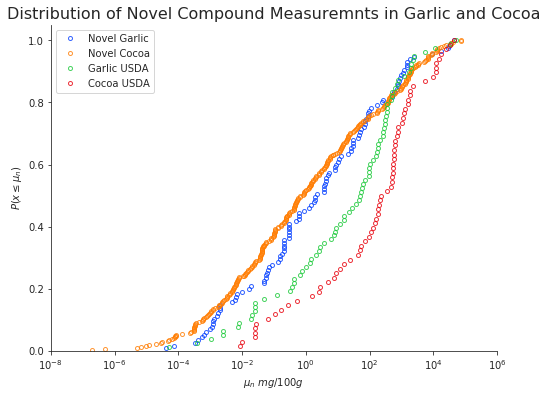

In [26]:
from matplotlib import ticker

sns.set_palette('bright')

with sns.axes_style('white'):

    marksize = 4
    domalpha = .8

    fig, ax = plt.subplots(figsize=(8,6))
    plt.semilogx(g_cdf.average_mean, g_cdf.cdf, marker='o', linewidth=0, fillstyle='none', label='Novel Garlic', alpha=domalpha, markersize=marksize)
    plt.semilogx(c_cdf.average_mean, c_cdf.cdf, marker='o', linewidth=0, fillstyle='none', label='Novel Cocoa', alpha=domalpha, markersize=marksize)

    plt.semilogx(usdag.conv_amount, usdag.cdf, marker='o', linewidth=0, fillstyle='none', label='Garlic USDA', alpha=domalpha, markersize=marksize)
    plt.semilogx(usdac.conv_amount, usdac.cdf, marker='o', linewidth=0, fillstyle='none', label='Cocoa USDA', alpha=domalpha, markersize=marksize)

    ax.set_ylim(bottom=0)
    ax.set_xlim(left = 10**-8, right=10**6)
    ax.legend()
    ax.set_xlabel('$\mu_n$ $mg/100g$')
    ax.set_ylabel('$P(x\leq\mu_n)$')
    ax.set_title('Distribution of Novel Compound Measuremnts in Garlic and Cocoa', fontsize=16)
    clean_plot()